# Covid-19 Chest X-ray Detector

Try to detect Covid-19 from X-rays, the datasets belongs to [covid-chestxray-dataset](https://github.com/ieee8023/covid-chestxray-dataset) and [chest-xray-pneumonia](https://www.kaggle.com/paultimothymooney/chest-xray-pneumonia)

There is 2 sources from X-rays because the first one have only X-rays with patologies, and the second one have normal X-rays.

**Processing dataset**
 * get only from back to front (Posteroanterior) X-rays. 
 * Keep only the fields 'finding', 'folder' and 'filename'
 * Change folder columns with the complete local path
 * Define the value to predict in setting "covid-19" and "covid-19, ARDS" field as true. Th eother will be set as false
 * Load a new dataset with imagee to have a balanced dataset and some "normal" case.
 
The new dataset have 304 X-rays images, with 152 covid-19 and 152 non covid-case. The non covid have normal case (109) and Streptococcus (13), Pneumocystis (12), SARS (8), ARDS (4), No Finding (2), Legionella (2), Klebsiella (1), Chlamydophila (1) cases

This dataset is save into **data/chestxrays.csv** file

In [305]:
# Import necessary packages
import os
import numpy as np
import pandas as pd

from keras.preprocessing.image import ImageDataGenerator

import seaborn as sns
import matplotlib.pyplot as plt
sns.set()

In [306]:
# Global defnitions
chestxray_images_folder = '../covid-chestxray-dataset'
chestxray_normal_folder = '../chest_xray/train/NORMAL'

In [307]:
# Load data from covid-chestxray-dataset and display 5 first rows
raw_data = pd.read_csv(os.path.join(chestxray_images_folder,'metadata.csv'))
raw_data.head()

,patientid,offset,sex,age,finding,survival,intubated,intubation_present,went_icu,in_icu,...,date,location,folder,filename,doi,url,license,clinical_notes,other_notes,Unnamed: 28
0,2,0.0,M,65.0,COVID-19,Y,NaN,NaN,NaN,NaN,...,"January 22, 2020","Cho Ray Hospital, Ho Chi Minh City, Vietnam",images,auntminnie-a-2020_01_28_23_51_6665_2020_01_28_...,10.1056/nejmc2001272,https://www.nejm.org/doi/full/10.1056/NEJMc200...,NaN,"On January 22, 2020, a 65-year-old man with a ...",NaN,NaN
1,2,3.0,M,65.0,COVID-19,Y,NaN,NaN,NaN,NaN,...,"January 25, 2020","Cho Ray Hospital, Ho Chi Minh City, Vietnam",images,auntminnie-b-2020_01_28_23_51_6665_2020_01_28_...,10.1056/nejmc2001272,https://www.nejm.org/doi/full/10.1056/NEJMc200...,NaN,"On January 22, 2020, a 65-year-old man with a ...",NaN,NaN
2,2,5.0,M,65.0,COVID-19,Y,NaN,NaN,NaN,NaN,...,"January 27, 2020","Cho Ray Hospital, Ho Chi Minh City, Vietnam",images,auntminnie-c-2020_01_28_23_51_6665_2020_01_28_...,10.1056/nejmc2001272,https://www.nejm.org/doi/full/10.1056/NEJMc200...,NaN,"On January 22, 2020, a 65-year-old man with a ...",NaN,NaN
3,2,6.0,M,65.0,COVID-19,Y,NaN,NaN,NaN,NaN,...,"January 28, 2020","Cho Ray Hospital, Ho Chi Minh City, Vietnam",images,auntminnie-d-2020_01_28_23_51_6665_2020_01_28_...,10.1056/nejmc2001272,https://www.nejm.org/doi/full/10.1056/NEJMc200...,NaN,"On January 22, 2020, a 65-year-old man with a ...",NaN,NaN
4,4,0.0,F,52.0,COVID-19,NaN,NaN,NaN,NaN,NaN,...,"January 25, 2020","Changhua Christian Hospital, Changhua City, Ta...",images,nejmc2001573_f1a.jpeg,10.1056/NEJMc2001573,https://www.nejm.org/doi/full/10.1056/NEJMc200...,NaN,diffuse infiltrates in the bilateral lower lungs,NaN,NaN


## Prepare dataset
To have a omogenous dataset we will keep only from back to front (Posteroanterior) X-rays. Because we are trying to predict covid from X-ray images, we wil keep only the fields 'finding', 'folder' and 'filename'. We also need to set the correct path for the images.

In [308]:
#  Get only Posteroanterior X-rays 
chestxrays = raw_data[(raw_data['modality'] == 'X-ray') & (raw_data['view'] == 'PA')]

In [309]:
# keep 'finding', 'folder' and 'filename'
col_to_drop = ['patientid', 'offset', 'sex', 'age', 'survival', 'intubated',
       'intubation_present', 'went_icu', 'in_icu', 'needed_supplemental_O2',
       'extubated', 'temperature', 'pO2_saturation', 'leukocyte_count',
       'neutrophil_count', 'lymphocyte_count', 'view', 'modality', 'date',
       'location', 'doi', 'url', 'license',
       'clinical_notes', 'other_notes', 'Unnamed: 28']

chestxrays = chestxrays.drop(col_to_drop, axis=1)

In [310]:
# Set correct path according to local installation
chestxrays['folder'] = chestxrays['folder'].apply(lambda folder: os.path.join(chestxray_images_folder,folder))

In [311]:
chestxrays.head()

,finding,folder,filename
0,COVID-19,../covid-chestxray-dataset/images,auntminnie-a-2020_01_28_23_51_6665_2020_01_28_...
1,COVID-19,../covid-chestxray-dataset/images,auntminnie-b-2020_01_28_23_51_6665_2020_01_28_...
2,COVID-19,../covid-chestxray-dataset/images,auntminnie-c-2020_01_28_23_51_6665_2020_01_28_...
3,COVID-19,../covid-chestxray-dataset/images,auntminnie-d-2020_01_28_23_51_6665_2020_01_28_...
4,COVID-19,../covid-chestxray-dataset/images,nejmc2001573_f1a.jpeg


## Define value to predict
When need to predict covid or not covid
change all 'finding' equal to 'COVID-19' to 1 and the others to 0 in a new col 'covid-19'


In [312]:
chestxrays["finding"].value_counts()

COVID-19          141
Streptococcus      13
Pneumocystis       12
COVID-19, ARDS     11
SARS                8
ARDS                4
No Finding          2
Legionella          2
Klebsiella          1
Chlamydophila       1
Name: finding, dtype: int64

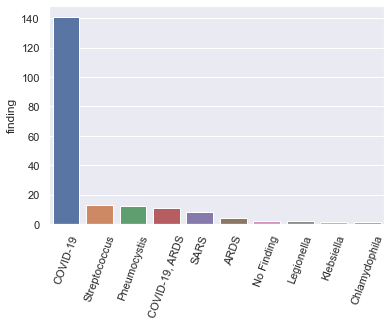

In [313]:
sns.barplot(x=chestxrays["finding"].value_counts().index, y=chestxrays["finding"].value_counts())
plt.xticks(rotation=70)
plt.show()

In [314]:
# nouvelle colonne covid-19 and drop 'finding' 
chestxrays['covid-19'] = chestxrays['finding'].map(lambda x:1 if (x == 'COVID-19' or x == 'COVID-19, ARDS') else 0)
chestxrays = chestxrays.drop(['finding'], axis=1)

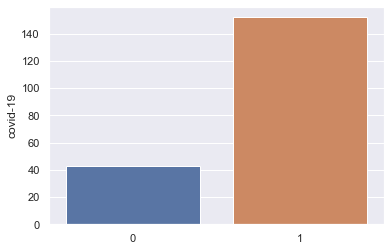

In [315]:
sns.barplot(x=chestxrays["covid-19"].value_counts().index, y=chestxrays["covid-19"].value_counts())
plt.show()

In [316]:
chestxrays["covid-19"].value_counts()

1    152
0     43
Name: covid-19, dtype: int64

In [317]:
chestxrays.head()

,folder,filename,covid-19
0,../covid-chestxray-dataset/images,auntminnie-a-2020_01_28_23_51_6665_2020_01_28_...,1
1,../covid-chestxray-dataset/images,auntminnie-b-2020_01_28_23_51_6665_2020_01_28_...,1
2,../covid-chestxray-dataset/images,auntminnie-c-2020_01_28_23_51_6665_2020_01_28_...,1
3,../covid-chestxray-dataset/images,auntminnie-d-2020_01_28_23_51_6665_2020_01_28_...,1
4,../covid-chestxray-dataset/images,nejmc2001573_f1a.jpeg,1


In [318]:
def display_random_images(df, nb_images):
    """Display x random images from dataset
    """
    random_index = [np.random.choice(df.index) for i in range(9)]        
    plt.figure(figsize=(20,10))
    for i in range(nb_images):        
        image = os.path.join(df.iloc[i]['folder'], df.iloc[i]['filename'])     
        plt.subplot(3, 3, i + 1)
        img = plt.imread(image)
        plt.imshow(img, cmap='gray')
        plt.axis('off')    
    plt.tight_layout()  

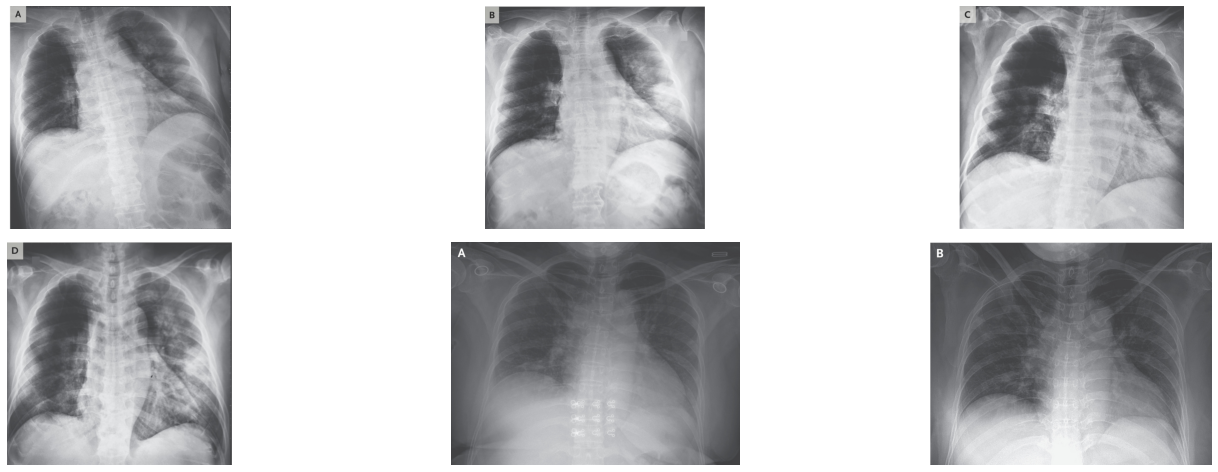

In [319]:
display_random_images(chestxrays, 6)

## Add new dataset
Add more non-covid chest X-rays from https://www.kaggle.com/paultimothymooney/chest-xray-pneumonia in directory train/NORMAL

In [326]:
nb_images_to_add = chestxrays["covid-19"].value_counts()[1] - chestxrays["covid-19"].value_counts()[0]
print(f"Number of normal images to add {nb_images_to_add}")

Number of normal images to add 109


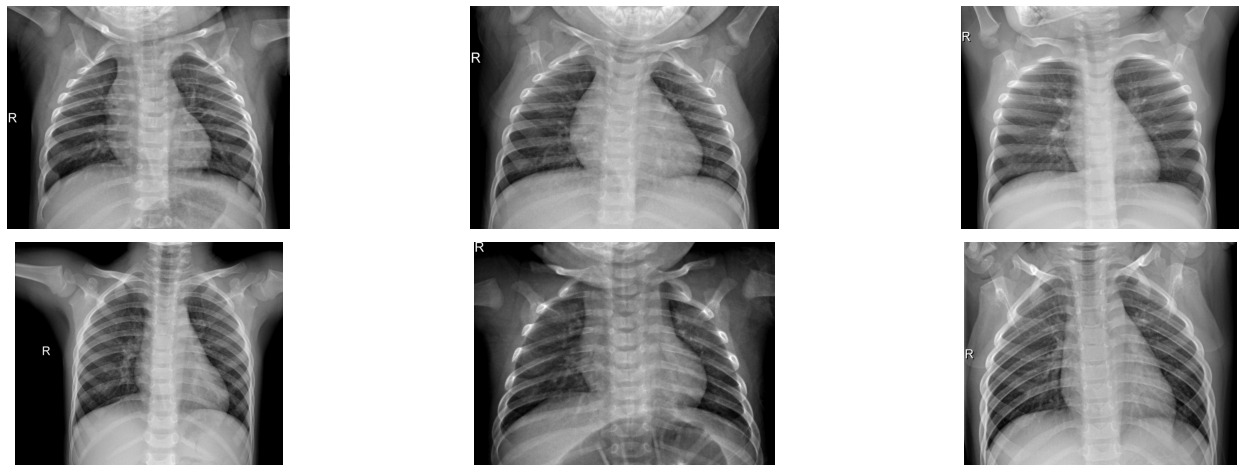

In [327]:
images = []
files = os.listdir(chestxray_normal_folder)
for name in files:
    images.append(name)
    
# Select randomly X images and add to new dataset
random_images = [np.random.choice(images) for i in range(nb_images_to_add)]    
column_names = ["folder","filename","covid-19"]
chests = pd.DataFrame(columns = column_names)

for image in random_images:
    new_row = pd.Series(data={'folder':chestxray_normal_folder, 'filename':image, 'covid-19':0})
    chests = chests.append(new_row, ignore_index=True)

    
display_random_images(chests, 6)

In [328]:
# Merge thge datasets
chestxrays = pd.concat([chestxrays, chests])

In [329]:
chestxrays["covid-19"].value_counts()

1    152
0    152
Name: covid-19, dtype: int64

In [330]:
# Save as CSV
chestxrays.to_csv('data/chestxrays.csv', index=False)